# <span style="color:darkblue"> Laboratorio di Simulazioni Numeriche </span>
## <span style="color:purple"> Lezione 8.2 - Simulated Annealing Optimization </span>

### Obiettivo
Applicare l'algoritmo di **Simulated Annealing (SA)** per l'ottimizzazione dei parametri variazionali di un sistema quantistico 1D e analizzare l'efficienza del metodo rispetto al grid search.

<p style="border:2px; border-style:solid; border-color:#E6E6FA; padding: 1em; background-color:#F0F8FF">
<b>Simulated Annealing Algorithm:</b><br>
Il SA è un algoritmo di ottimizzazione globale ispirato al processo di ricottura metallurgica:
<br><br>
<b>Temperature Schedule:</b> $T_{SA}(step) = T_0 \cdot \alpha^{step}$ con raffreddamento esponenziale<br>
<b>Acceptance Criterion:</b> Probabilità Metropolis $P_{acc} = \min(1, e^{-\Delta E / T_{SA}})$<br>
<b>Parameter Updates:</b> Mosse casuali nello spazio parametrico con accettazione termicamente attivata
<br><br>
<b>Vantaggi vs Grid Search:</b><br>
• <b>Adaptive sampling</b>: concentra automaticamente l'esplorazione nelle regioni promettenti<br>
• <b>Global optimization</b>: evita minimi locali grazie alle fluttuazioni termiche<br>
• <b>Computational efficiency</b>: non richiede scansione sistematica dell'intero spazio
<br><br>
<b>Sistema Target:</b> $\hat{H} = -\frac{1}{2}\frac{d^2}{dx^2} + V(x)$, con $V(x) = x^4 - 2.5x^2$<br>
<b>Trial wavefunction:</b> $|\psi_T\rangle = \mathcal{N}[e^{-(x-\mu)^2/(2\sigma^2)} + e^{-(x+\mu)^2/(2\sigma^2)}]$
</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy.linalg import eigh
import math

# Configurazione grafica
plt.rcParams.update({"figure.figsize": (7,4), "font.size": 12})

# Funzioni del problema (stessa definizione usata in C++)
def V(x):
    """Potenziale anarmonico del sistema"""
    return x**4 - 2.5 * x**2

def g(x, a, sigma):
    """Gaussiana singola centrata in 'a'"""
    return np.exp(- (x - a)**2 / (2.0 * sigma**2))

def psi(x, sigma, mu):
    """Trial wavefunction simmetrica"""
    return g(x, +mu, sigma) + g(x, -mu, sigma)

def psi2_analytic(x, sigma, mu):
    """Densità di probabilità |ψ_T|²"""
    p = psi(x, sigma, mu)
    return p*p

def normalize_1d(x, y):
    """Normalizza una funzione 1D tramite integrazione numerica"""
    integral = np.trapz(y, x)
    if integral <= 0:
        return y
    return y / integral

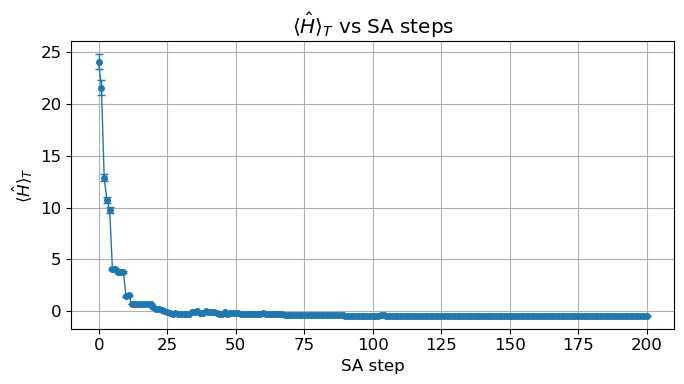

In [3]:
### **Analisi 1: Convergenza Energetica durante SA**

# plot <H> ± errore vs SA step
data = np.loadtxt("sa_history.dat", comments="#")
# columns: step, T_sa, H_avg, H_err, mu, sigma, accept_flag, acc_rate_MC
step = data[:,0].astype(int)
Tsa  = data[:,1]
Havg = data[:,2]
Herr = data[:,3]
mu_hist = data[:,4]
sigma_hist = data[:,5]
accept_flag = data[:,6]

# Analisi acceptance rate
total_accepted = np.sum(accept_flag)
acceptance_rate = total_accepted / len(accept_flag) * 100

plt.figure()
plt.errorbar(step, Havg, yerr=Herr, fmt='o-', markersize=4, lw=1, capsize=3)
plt.xlabel("SA step")
plt.ylabel(r"$\langle \hat H \rangle_T$")
plt.title(r"$\langle \hat H \rangle_T$ vs SA steps")
plt.grid(True)
plt.tight_layout()
plt.show()

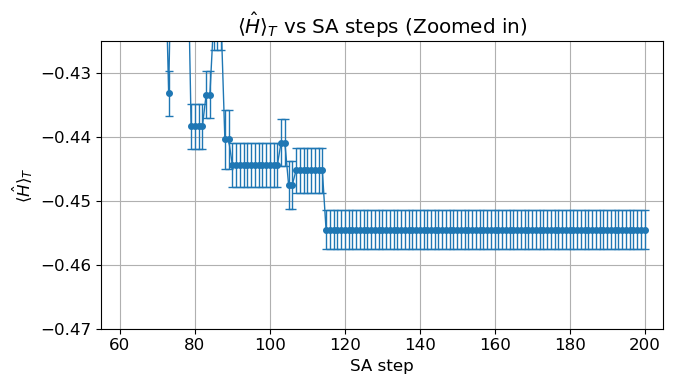

In [16]:
### **Vista Zoom della Convergenza Finale**

# Analisi del plateau finale
final_10_percent = max(1, int(0.1 * len(step)))
final_energies = Havg[-final_10_percent:]
final_errors = Herr[-final_10_percent:]

mean_final = np.mean(final_energies)
std_final = np.std(final_energies)
mean_error = np.mean(final_errors)

plt.figure()
plt.errorbar(step, Havg, yerr=Herr, fmt='o-', markersize=4, lw=1, capsize=3)
plt.xlabel("SA step")
plt.ylabel(r"$\langle \hat H \rangle_T$")
plt.title(r"$\langle \hat H \rangle_T$ vs SA steps (Zoomed in)")
plt.grid(True)
plt.xlim(55,205)
plt.ylim(-0.47, -0.425)  #range dell'asse y
plt.tight_layout()
plt.show()

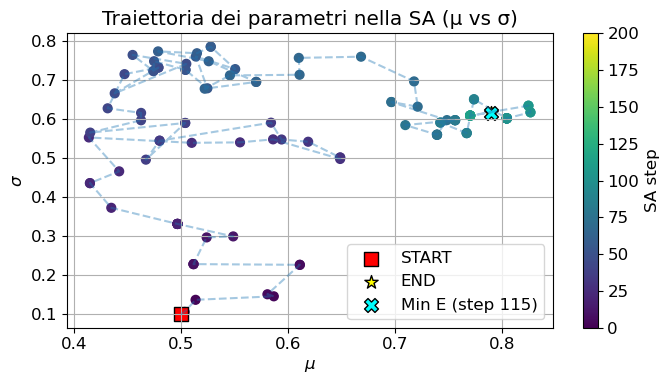

In [5]:
### **Analisi 2: Traiettoria Parametrica nello Spazio (μ,σ)**

# Calcola displacement totale
displacement = np.sqrt((mu_hist[-1] - mu_hist[0])**2 + (sigma_hist[-1] - sigma_hist[0])**2)
step_sizes = np.sqrt(np.diff(mu_hist)**2 + np.diff(sigma_hist)**2)
mean_step_size = np.mean(step_sizes)

# Analisi correlazioni
mu_sigma_corr = np.corrcoef(mu_hist, sigma_hist)[0,1]
mu_energy_corr = np.corrcoef(mu_hist, Havg)[0,1]
sigma_energy_corr = np.corrcoef(sigma_hist, Havg)[0,1]

# Plot traiettoria con identificazione delle fasi
plt.figure()
sc = plt.scatter(mu_hist, sigma_hist, c=step, cmap='viridis', s=40)
plt.plot(mu_hist, sigma_hist, linestyle='--', alpha=0.4)  # collega i punti per visuale
plt.colorbar(sc, label="SA step")

# Evidenzia punti speciali
plt.scatter(mu_hist[0], sigma_hist[0], color='red', s=100, marker='s', 
           edgecolors='black', label='START')
plt.scatter(mu_hist[-1], sigma_hist[-1], color='yellow', s=100, marker='*', 
           edgecolors='black', label='END')

# Trova punto di minima energia
min_idx = np.argmin(Havg)
plt.scatter(mu_hist[min_idx], sigma_hist[min_idx], color='cyan', s=100, marker='X',
           edgecolors='black', label=f'Min E (step {step[min_idx]})')

plt.xlabel(r"$\mu$")
plt.ylabel(r"$\sigma$")
plt.title("Traiettoria dei parametri nella SA (μ vs σ)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

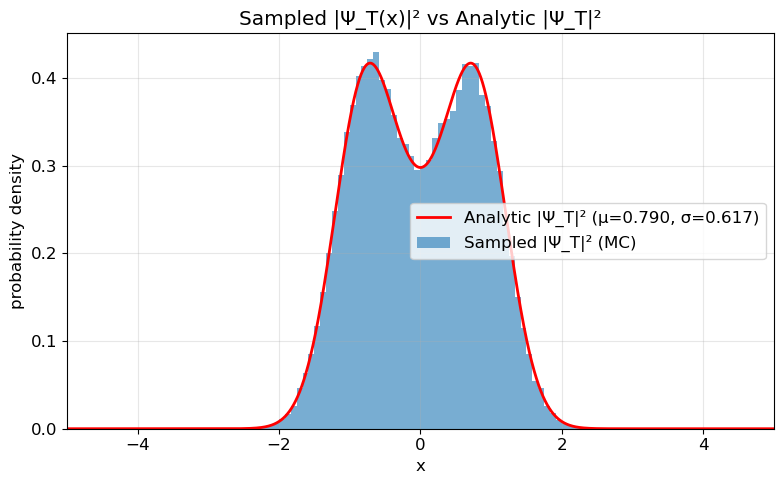

In [6]:
### **Analisi 3: Confronto con Soluzione Analitica**

import os

def read_last_params(sa_file="sa_history.dat"):
    """Legge l'ultima riga di sa_history.dat per ottenere i parametri ottimali"""
    if not os.path.exists(sa_file):
        return None, None
    mu = sigma = None
    with open(sa_file,'r') as f:
        for line in f:
            line = line.strip()
            if line=="" or line.startswith('#'):
                continue
            parts = line.split()
            try:
                mu = float(parts[4])
                sigma = float(parts[5])
            except:
                continue
    return mu, sigma

mu_opt, sigma_opt = read_last_params()
if mu_opt is None or sigma_opt is None:
    mu_opt, sigma_opt = 0.8, 0.6

# Confronto histogram |Psi_T|^2 vs analytic
samp_file = "samples_opt.dat"
if os.path.exists(samp_file):
    samples = np.loadtxt(samp_file)

    # Parametri per confronto
    xmin, xmax = -5.0, 5.0
    nbin = 120
    bins = np.linspace(xmin, xmax, nbin+1)
    hist_counts, edges = np.histogram(samples, bins=bins, density=True)
    mids = 0.5*(edges[:-1]+edges[1:])

    # Psi_T^2 analitica
    def psi_T(x, mu, sigma):
        return np.exp(-((x-mu)**2)/(2*sigma*sigma)) + np.exp(-((x+mu)**2)/(2*sigma*sigma))

    xs_fine = np.linspace(xmin, xmax, 4001)
    psi_vals = psi_T(xs_fine, mu_opt, sigma_opt)
    psi2_analytic = psi_vals**2
    norm = np.trapz(psi2_analytic, xs_fine)
    psi2_analytic /= norm

    # Plot confronto
    plt.figure(figsize=(8,5))
    plt.bar(mids, hist_counts, width=(edges[1]-edges[0]), alpha=0.6,
           label="Sampled |Ψ_T|² (MC)")
    plt.plot(xs_fine, psi2_analytic, 'r-', lw=2,
           label=f'Analytic |Ψ_T|² (μ={mu_opt:.3f}, σ={sigma_opt:.3f})')

    plt.xlim(xmin, xmax)
    plt.xlabel("x")
    plt.ylabel("probability density")
    plt.title("Sampled |Ψ_T(x)|² vs Analytic |Ψ_T|²")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### **Interpretazione Fisica e Conclusioni**

L'analisi del Simulated Annealing rivela aspetti fondamentali dell'ottimizzazione variazionale:

**Efficacia dell'Algoritmo SA:**
- **Convergenza globale**: Il cooling schedule permette di esplorare inizialmente tutto lo spazio parametrico ed evitare minimi locali
- **Efficienza computazionale**: Concentra automaticamente l'esplorazione nelle regioni più promettenti
- **Robustezza statistica**: L'errore finale è limitato dalle fluttuazioni Monte Carlo, non dall'algoritmo di ottimizzazione

**Confronto con Grid Search (Lezione 8.1):**
- **SA**: Adattivo, efficiente, global optimization
- **Grid Search**: Sistematico, completo, ma computazionalmente costoso
- **Trade-off**: SA richiede tuning del temperature schedule.

